# RandomForest Regressor
Haytham Mohamed

INFS 890 - Spring 2020

In [462]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn import preprocessing, metrics, feature_selection
from datetime import datetime
from scipy import stats
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.3f}'.format

Set this flag to True if you're using reduction feature using FCA, otherwise set it to False

In [463]:
# 1- read data file
# 1- read processed file
file_dir = '../data/processed-data/'


data_file = 'no_missing_outliers_dataset.csv'
#data_file = 'factored_dataset.csv'
#data_file = 'standardized_normalized_dataset.csv'
#data_file = 'normalized_dataset.csv'


data = pd.read_csv(file_dir + data_file)

test_split=0.1


In [464]:
data.head(5)

svc_cpu_use  svc_cpu_thr  svc_net_use  svc_disk_use  system_cpu_use  \
0        0.310        0.110        0.106         0.001           2.030   
1        0.380        0.090        0.123         0.002           2.130   
2        0.370        0.100        0.131         0.002           2.100   
3        0.390        0.090        0.131         0.012           2.040   
4        0.370        0.100        0.140         0.018           2.020   

   system_cpu_sat  system_net_use  system_net_sat  system_disk_sat  \
0           1.261           3.206           0.000            0.980   
1           1.268           3.552           0.000            0.980   
2           1.179           3.586           0.000            0.980   
3           1.315           3.512           0.000            0.980   
4           1.385           3.449           0.000            0.980   

   system_disk_io  svc_req_size  svc_resp_size  svc_pods  svc_req_rate  ltcy  
0           0.010         0.002          0.012     7.000         0.980 0.110  
1           0.010         0.003          0.019     7.000         1.620 0.160  
2           0.010         0.003          0.024     7.000         2.180 0.220  
3           0.010         0.003          0.022     6.000         2.130 0.240  
4           0.010         0.003          0.023     3.000         2.220 0.250

In [465]:
data.shape

(1584, 15)

In [466]:
targets = data['ltcy']
inputs = data.drop(['ltcy'], axis=1)

n_features = inputs.values.shape[1]

x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=test_split, shuffle=False, random_state=365)

# for better convergence and result scale target to values between 0 - 1
y_train_max = y_train.max()
y_test_max = y_test.max()

y_train = y_train / y_train_max
y_test = y_test / y_test_max

print("there are {} features".format(n_features))

there are 14 features


In [467]:
# Regression

# start:  search grid

randforest = RandomForestRegressor() #(n_estimators=tree_n_estimators, max_features=tree_n_features)

# standardize the features
scaler = StandardScaler()

# no feastures selection needed for RandomTree Regressor
pipe = Pipeline(steps=[
    ('scaler', scaler),
    ('clf', randforest)
])

kfold = KFold(n_splits=10, shuffle=False)

param_grid = {
    'clf__max_features': [11, 9, 7, 5, 3]   # The maximum number of features to consider
    ,'clf__n_estimators': [10, 8, 6, 4, 2, 1]  # The number of trees in the forest 
}


search = GridSearchCV(pipe
                      , param_grid
                      , scoring='neg_mean_squared_error'
                      , return_train_score= True
                      , cv=kfold
                      , verbose=0
                      , n_jobs=-1)

search.fit(x_train, y_train)


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('clf',
                                        RandomForestRegressor(bootstrap=True,
                                                              ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              max_sampl

# Best Model

In [468]:
estimator = search.best_estimator_
params = search.best_params_
score = search.best_score_

print("Best CV score = %0.3f:" % score)
print("Best CV params = {}".format(params))

print("")
all_training_scores = search.cv_results_
#print("\ncross_validation:\n", all_training_scores , "\n")
print(all_training_scores['mean_train_score'])

print("")
print('Model training Score = {}'.format(search.score(x_train,y_train)))

Best CV score = -0.042:
Best CV params = {'clf__max_features': 5, 'clf__n_estimators': 10}

[-0.00410548 -0.00442872 -0.00492734 -0.00615148 -0.00960816 -0.01626251
 -0.0040628  -0.00439731 -0.00493436 -0.00616421 -0.00946525 -0.01599329
 -0.00407103 -0.00435676 -0.0049152  -0.00603063 -0.00942865 -0.01554169
 -0.00412438 -0.0045029  -0.00519798 -0.00610802 -0.00942639 -0.01578017
 -0.00419248 -0.00456289 -0.00509024 -0.00642308 -0.00975096 -0.01670783]

Model training Score = -0.003933617507977394


# Training R2

In [469]:
score = search.score(x_train, y_train)
score

-0.003933617507977394

In [470]:
#scaler.fit(x_train.values.reshape(-1,n_features))
#x_train = scaler.transform(x_train)

y_hat = search.predict(x_train)

r2_train = metrics.r2_score(y_train, y_hat)
print('R2 (training) = {}'.format(r2_train))


R2 (training) = 0.8992455383782577


In [471]:
# validation mean_absolute_percentage_error
train_error =  np.abs(y_train - y_hat)
mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)


print("Model Result (mean - std of error - min - max): %.2f (%.2f) %.2f %.2f MSE" \
      % (mean_error, std_error, min_error, max_error))

Model Result (mean - std of error - min - max): 0.05 (0.04) 0.00 0.28 MSE


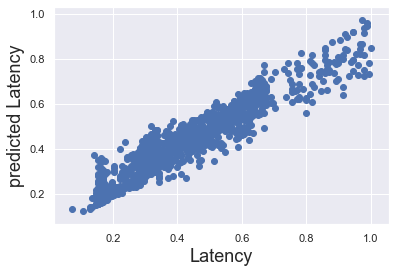

In [472]:
plt.scatter(y_train, y_hat)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
#plt.xlim(-2,3)
#plt.ylim(-3,1)
plt.show()

Text(0.5, 1.0, 'Residual PDF')

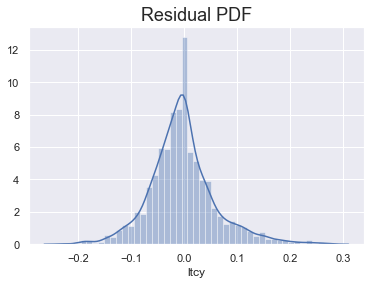

In [473]:
sns.distplot(y_train - y_hat)
plt.title('Residual PDF', size=18)

# Testing

In [474]:
y_hat_test = search.predict(x_test)

<function matplotlib.pyplot.show(*args, **kw)>

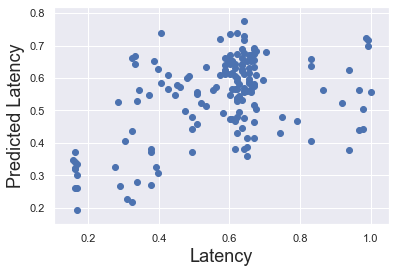

In [475]:
plt.scatter(y_test, y_hat_test)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

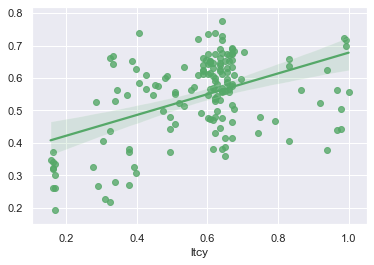

In [476]:
ax = sns.regplot(x=y_test, y=y_hat_test, color='g')

In [477]:
perf = pd.DataFrame(np.exp(y_hat_test), columns=['prediction'])
y_test = y_test.reset_index(drop=True)
perf['target'] = np.exp(y_test)
perf.head()

prediction  target
0       1.700   1.402
1       1.744   1.939
2       1.557   1.638
3       1.615   1.638
4       1.563   1.887

In [478]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

prediction  target  residual  difference%
0         1.700   1.402     0.298       21.236
1         1.744   1.939    -0.195       10.065
2         1.557   1.638    -0.081        4.941
3         1.615   1.638    -0.023        1.409
4         1.563   1.887    -0.324       17.181
..          ...     ...       ...          ...
154       1.823   1.616     0.208       12.856
155       1.921   1.837     0.084        4.560
156       1.909   1.837     0.072        3.926
157       2.056   1.776     0.280       15.792
158       2.047   1.900     0.147        7.716

[159 rows x 4 columns]

In [479]:
perf.describe()

prediction  target  residual  difference%
count     159.000 159.000   159.000      159.000
mean        1.734   1.811    -0.078       11.991
std         0.211   0.337     0.319       10.656
min         1.213   1.168    -1.108        0.135
25%         1.598   1.621    -0.176        3.677
50%         1.762   1.862    -0.023        8.841
75%         1.898   1.926     0.103       17.572
max         2.171   2.718     0.590       42.887

In [480]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
perf.sort_values(by = ['difference%'])

prediction  target  residual  difference%
135        1.68    1.68      0.00         0.14
137        1.46    1.46      0.00         0.20
19         1.96    1.95      0.01         0.41
94         1.92    1.91      0.01         0.47
101        1.45    1.46     -0.01         0.54
55         1.98    1.97      0.01         0.61
90         1.90    1.89      0.01         0.61
50         1.85    1.84      0.01         0.75
24         1.87    1.89     -0.02         0.87
74         1.92    1.94     -0.02         0.87
37         1.96    1.94      0.02         0.88
152        1.76    1.74      0.02         0.88
20         1.91    1.89      0.02         0.95
86         1.97    1.95      0.02         0.95
47         1.83    1.85     -0.02         1.01
30         1.84    1.82      0.02         1.02
38         1.93    1.95     -0.02         1.21
15         1.77    1.75      0.02         1.22
3          1.61    1.64     -0.02         1.41
32         1.86    1.89     -0.03         1.41
28         1.88    1.85      0.03         1.70
87         1.96    1.93      0.03         1.70
139        1.67    1.71     -0.03         2.01
51         1.82    1.86     -0.04         2.07
67         1.99    1.95      0.04         2.19
80         1.97    2.02     -0.05         2.27
65         1.88    1.93     -0.05         2.34
102        1.31    1.34     -0.03         2.34
111        1.21    1.18      0.03         2.46
68         2.00    1.95      0.05         2.46
136        1.65    1.60      0.04         2.53
61         1.85    1.80      0.05         2.60
25         1.94    1.89      0.05         2.67
13         1.91    1.85      0.06         3.02
75         1.84    1.90     -0.06         3.06
59         1.80    1.86     -0.06         3.19
26         1.86    1.80      0.06         3.30
18         1.89    1.95     -0.07         3.39
63         1.97    1.90      0.07         3.51
14         1.84    1.78      0.06         3.58
62         1.85    1.93     -0.07         3.78
120        1.87    1.80      0.07         3.79
156        1.91    1.84      0.07         3.93
27         1.76    1.84     -0.08         4.17
21         1.90    1.82      0.08         4.21
143        1.73    1.66      0.07         4.35
89         1.79    1.87     -0.08         4.49
155        1.92    1.84      0.08         4.56
29         1.92    1.84      0.08         4.56
33         1.76    1.85     -0.09         4.62
128        1.58    1.66     -0.08         4.75
126        1.38    1.32      0.06         4.84
2          1.56    1.64     -0.08         4.94
142        1.75    1.66      0.09         5.20
88         1.96    1.86      0.10         5.27
52         1.73    1.82     -0.10         5.33
48         1.90    1.80      0.10         5.34
23         1.76    1.86     -0.10         5.39
35         1.99    1.89      0.11         5.70
114        1.32    1.40     -0.08         5.77
71         1.81    1.93     -0.11         5.77
153        1.92    1.81      0.11         6.13
54         1.84    1.97     -0.12         6.34
66         1.80    1.93     -0.12         6.47
103        1.38    1.48     -0.10         6.47
57         1.77    1.90     -0.13         6.91
72         1.79    1.93     -0.13         6.91
8          1.96    1.82      0.13         7.35
49         1.94    1.80      0.14         7.64
158        2.05    1.90      0.15         7.72
39         1.71    1.86     -0.15         7.91
7          1.75    1.90     -0.15         7.97
56         1.72    1.87     -0.15         8.04
110        1.25    1.36     -0.11         8.10
42         1.75    1.90     -0.16         8.16
73         1.79    1.95     -0.16         8.29
58         1.71    1.86     -0.16         8.35
53         1.63    1.79     -0.15         8.59
148        1.75    1.91     -0.16         8.59
104        1.36    1.49     -0.13         8.84
40         1.70    1.86     -0.17         8.90
91         1.78    1.95     -0.17         8.96
79         1.76    1.94     -0.18         9.15
64         2.07    1.90      0.17         9.18
105       

# Prediction Accuracy

In [481]:
r2_test = metrics.r2_score(y_test, y_hat_test)
print('R2 (testing) = {}'.format(r2_test))

# also: R-Squared could obtain with
# pline.score(x_test, y_test)

R2 (testing) = 0.14418583735053792


In [482]:
print(np.sqrt(mean_squared_error(y_test,y_hat_test)))

0.17277509052242163
